In [143]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [118]:
YEARS = range(2014, 2025)
DATA_DIR = '../data'

In [119]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [120]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,400548974,2014,1,regular,True,False,3906.0,331,Eastern Washington,Big Sky,fcs,56.0,NaN,2534,Sam Houston,Southland,fcs,35.0,NaN
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,38.0,NaN,2000,Abilene Christian,Southland,fcs,37.0,NaN
2,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,28.0,1863.0,245,Texas A&M,SEC,fbs,52.0,1765.0
3,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,17.0,1304.0,154,Wake Forest,ACC,fbs,10.0,1377.0
4,400557394,2014,1,regular,True,False,3658.0,2127,Charleston Southern,Big South,fcs,61.0,NaN,3179,Point University,None,None,9.0,NaN


In [121]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,400610221,2014,1,postseason,2014-12-20 20:30:00+00:00,False,Colorado State,Mountain West,Utah,Pac-12,3914,Sam Boyd Stadium,53.6,43.0,67.0,0.0,0,180.0,0.0,1022.5,NaN,None
1,400610199,2014,1,postseason,2014-12-24 02:30:00+00:00,False,San Diego State,Mountain West,Navy,FBS Independents,3932,Qualcomm Stadium,68.0,54.1,61.0,0.0,0,100.0,0.0,1017.5,NaN,None
2,400548409,2014,2,regular,2014-09-06 18:00:00+00:00,False,Georgia State,Sun Belt,New Mexico State,Sun Belt,3495,Georgia Dome,87.1,66.7,51.0,0.0,0,360.0,0.0,1015.3,NaN,None
3,400548252,2014,14,regular,2014-11-30 03:30:00+00:00,False,UNLV,Mountain West,Nevada,Mountain West,3914,Sam Boyd Stadium,64.4,21.2,19.0,0.0,0,220.0,0.0,1008.5,NaN,None
4,400609076,2014,15,regular,2014-12-06 02:20:00+00:00,False,Oregon,Pac-12,Arizona,Pac-12,4738,Levi's Stadium,62.1,57.7,86.0,0.0,0,180.0,0.0,1016.3,NaN,None


In [122]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [123]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476401,1,False,1,35,35,1,63,63,6,18,PUNT,False,0,0,0,0,15,0,12,7
1,Vanderbilt,SEC,Temple,American Athletic,400547640,4005476402,2,False,1,28,72,1,31,69,3,3,PUNT,True,0,0,0,0,12,7,10,4
2,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476403,3,False,1,73,73,1,64,64,3,9,PUNT,False,0,0,0,0,10,4,8,26
3,Vanderbilt,SEC,Temple,American Athletic,400547640,4005476404,4,False,1,21,79,1,25,75,3,4,PUNT,True,0,0,0,0,8,26,6,44
4,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476405,5,False,1,64,64,1,75,75,3,-11,PUNT,False,0,0,0,0,6,44,5,36


In [124]:
punt_events = [c for c in df_drives.drive_result.unique() if 'PUNT' in c]
print(punt_events)
df_drives = df_drives[df_drives.drive_result.isin(punt_events)].reset_index(drop=True)
df_drives.shape

['PUNT', 'PUNT TD', 'PUNT RETURN TD', 'BLOCKED PUNT']


(104337, 26)

In [125]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2014,1,2,Auburn,fbs,2843.024150
2,2014,2,2,Auburn,fbs,2812.632195
3,2014,4,2,Auburn,fbs,2823.244101
4,2014,5,2,Auburn,fbs,2874.578031
5,2014,6,2,Auburn,fbs,2879.393357


## 2. Join and Filter the Data

In [126]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number', 'start_yards_to_goal',
       'end_yards_to_goal', 'drive_result',
       'end_offense_score', 'end_defense_score',
       'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']
elo_cols = ['season', 'week', 'team_id', 'elo']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)

df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484033,3.0,67.0,42.0,PUNT,3.0,0.0,0.0,3.0,1.0,6.0,16.0,1.0,4.0,15.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False,794.158935,1399.063147
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484035,5.0,71.0,27.0,PUNT,3.0,7.0,7.0,3.0,1.0,2.0,41.0,1.0,0.0,29.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False,794.158935,1399.063147
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,4005484038,8.0,81.0,27.0,PUNT,14.0,6.0,6.0,14.0,2.0,7.0,31.0,2.0,5.0,14.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False,794.158935,1399.063147
3,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,40054840314,14.0,83.0,29.0,PUNT,21.0,16.0,16.0,21.0,3.0,15.0,0.0,3.0,12.0,45.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False,794.158935,1399.063147
4,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840315,15.0,71.0,28.0,PUNT,16.0,21.0,21.0,16.0,3.0,12.0,45.0,3.0,11.0,21.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False,794.158935,1399.063147


In [127]:
df.drive_result.value_counts()

drive_result
PUNT              103517
PUNT TD              428
PUNT RETURN TD       382
BLOCKED PUNT          10
Name: count, dtype: int64

## 3. Feature Engineering

In [128]:
df = df.assign(
    end_drive_pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    start_drive_pct_game_played = (((df['start_period'] - 1) * 15 * 60) + ((15 * 60) - (df['start_time_minutes'] * 60 + df['start_time_seconds']))) / (4 * 15 * 60),
    score_diff = df['end_offense_score'] - df['end_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    punting_team_pregame_elo = np.where(df.home_team == df.offense, df.home_pregame_elo, df.away_pregame_elo),
    receiving_team_pregame_elo = np.where(df.home_team == df.offense, df.away_pregame_elo, df.home_pregame_elo),
    receiving_team_points_scored = df.end_defense_score - df.start_defense_score,
    punting_team_points_scored = df.end_offense_score - df.start_offense_score,
)

df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34514/537318917.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34514/537318917.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,end_drive_pct_game_played,start_drive_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484033,3.0,67.0,42.0,PUNT,3.0,0.0,0.0,3.0,1.0,6.0,16.0,1.0,4.0,15.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.179167,0.145556,3.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484035,5.0,71.0,27.0,PUNT,3.0,7.0,7.0,3.0,1.0,2.0,41.0,1.0,0.0,29.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.241944,0.205278,-4.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,4005484038,8.0,81.0,27.0,PUNT,14.0,6.0,6.0,14.0,2.0,7.0,31.0,2.0,5.0,14.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.412778,0.374722,8.0,0,fbs,fcs,794.158935,1399.063147,0.0,0.0
3,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,40054840314,14.0,83.0,29.0,PUNT,21.0,16.0,16.0,21.0,3.0,15.0,0.0,3.0,12.0,45.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.537500,0.500000,5.0,0,fbs,fcs,794.158935,1399.063147,0.0,0.0
4,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840315,15.0,71.0,28.0,PUNT,16.0,21.0,21.0,16.0,3.0,12.0,45.0,3.0,11.0,21.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.560833,0.537500,-5.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0


In [129]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,end_drive_pct_game_played,start_drive_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484033,3.0,67.0,42.0,PUNT,3.0,0.0,0.0,3.0,1.0,6.0,16.0,1.0,4.0,15.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.179167,0.145556,3.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484035,5.0,71.0,27.0,PUNT,3.0,7.0,7.0,3.0,1.0,2.0,41.0,1.0,0.0,29.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.241944,0.205278,-4.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,4005484038,8.0,81.0,27.0,PUNT,14.0,6.0,6.0,14.0,2.0,7.0,31.0,2.0,5.0,14.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.412778,0.374722,8.0,0,fbs,fcs,794.158935,1399.063147,0.0,0.0
3,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,40054840314,14.0,83.0,29.0,PUNT,21.0,16.0,16.0,21.0,3.0,15.0,0.0,3.0,12.0,45.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.537500,0.500000,5.0,0,fbs,fcs,794.158935,1399.063147,0.0,0.0
4,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840315,15.0,71.0,28.0,PUNT,16.0,21.0,21.0,16.0,3.0,12.0,45.0,3.0,11.0,21.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.560833,0.537500,-5.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0


In [130]:
feasible_receiving_team_points_scored = [0, 6, 7, 8] # Disregarding the possibility of a safetys against punting team
feasible_punting_team_points_scored = [0, 2] # Disregarding the possibility of touchdowns scored by the punting team

df_punts = (
    df
    .rename(columns={
        'end_yards_to_goal':'punt_team_end_yards_to_goal',
        'end_drive_pct_game_played':'punt_team_end_pct_game_played',
    })
    .merge(
        (
            df[['game_id','drive_number','start_drive_pct_game_played','start_yards_to_goal']]
            .rename(columns={
                'start_yards_to_goal':'receiving_team_start_yards_to_goal',
                'start_drive_pct_game_played':'receiving_team_start_pct_game_played'
            })
            .assign(drive_number=lambda x: x['drive_number'] - 1)
        ),
        on=['game_id','drive_number'],
        how='left'
    )
    .dropna(subset=['receiving_team_start_yards_to_goal'])
    .query('receiving_team_points_scored in @feasible_receiving_team_points_scored and '
           'punting_team_points_scored in @feasible_punting_team_points_scored')
    .query('receiving_team_start_pct_game_played != 0.5')
    .drop(columns=['start_drive_pct_game_played'])
)

conditions = [
    df_punts.receiving_team_points_scored.isin([6,7,8]),
    df_punts.punting_team_points_scored == 2,
]
choices = [
    0,
    100
]
df_punts['receiving_team_start_yards_to_goal'] = np.select(conditions, choices, default=df_punts['receiving_team_start_yards_to_goal'])

In [131]:
df_punts.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,punt_team_end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,punt_team_end_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,receiving_team_start_pct_game_played,receiving_team_start_yards_to_goal
3,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Georgia State,Abilene Christian,40054840314,14.0,83.0,29.0,PUNT,21.0,16.0,16.0,21.0,3.0,15.0,0.0,3.0,12.0,45.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.537500,5.0,0,fbs,fcs,794.158935,1399.063147,0.0,0.0,0.537500,71.0
4,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840315,15.0,71.0,28.0,PUNT,16.0,21.0,21.0,16.0,3.0,12.0,45.0,3.0,11.0,21.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,794.158935,1399.063147,0.560833,-5.0,0,fcs,fbs,1399.063147,794.158935,0.0,0.0,0.560833,72.0
9,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,Texas A&M,South Carolina,4005484025,5.0,75.0,25.0,PUNT,10.0,7.0,7.0,10.0,1.0,3.0,44.0,1.0,1.0,50.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.545486,True,3139.747407,2908.217506,0.219444,3.0,-1,fbs,fbs,2908.217506,3139.747407,0.0,0.0,0.219444,75.0
14,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,154,Wake Forest,ACC,fbs,Wake Forest,UL Monroe,4005478291,1.0,85.0,29.0,PUNT,0.0,0.0,0.0,0.0,1.0,15.0,0.0,1.0,12.0,57.0,False,82.9,72.1,70.0,0.0,0.0,4.7,1013.0,None,22.998209,False,1496.329278,1969.442551,0.034167,0.0,-1,fbs,fbs,1969.442551,1496.329278,0.0,0.0,0.034167,71.0
16,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,154,Wake Forest,ACC,fbs,Wake Forest,UL Monroe,4005478294,4.0,66.0,19.0,PUNT,7.0,0.0,0.0,7.0,1.0,6.0,49.0,1.0,5.0,1.0,False,82.9,72.1,70.0,0.0,0.0,4.7,1013.0,None,22.998209,False,1496.329278,1969.442551,0.166389,7.0,-1,fbs,fbs,1969.442551,1496.329278,0.0,0.0,0.166389,81.0


In [132]:
# Filter out overtime plays
df_punts = df_punts.query('0 < end_period <= 4')

# Game must be completed
df_punts = df_punts.query('completed == True')

df_punts = df_punts.query('0 <= receiving_team_start_pct_game_played <= 1')
df_punts = df_punts.query('0 <= punt_team_end_pct_game_played <= 1')

df_punts.reset_index(drop=True, inplace=True)

## 4. Feature Data Viz

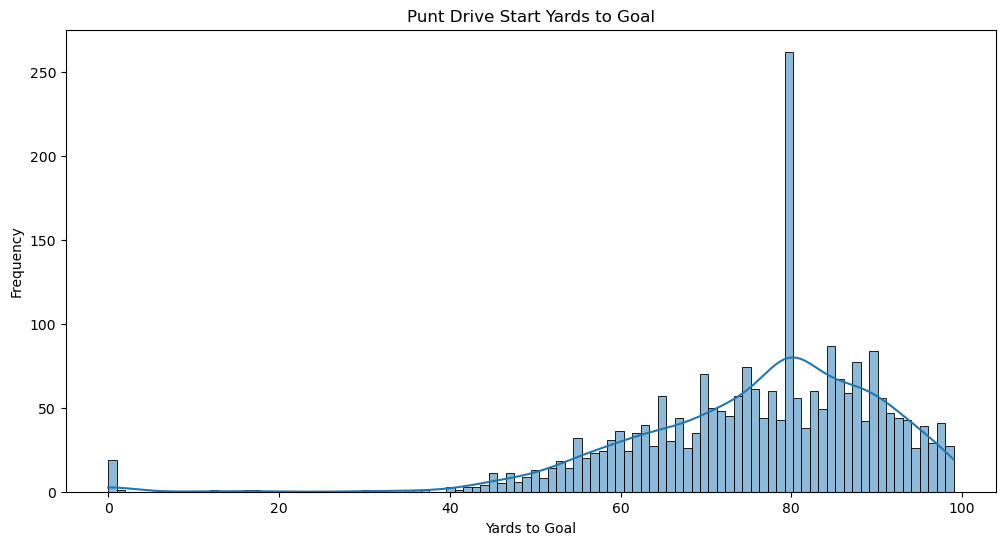

In [133]:
# plot a histogram of punt drive start yards to goal
plt.figure(figsize=(12,6))
sns.histplot(df_punts.query('season == 2024 and home_division == "fbs" and away_division == "fbs"').receiving_team_start_yards_to_goal, bins=100, kde=True)
plt.title("Punt Drive Start Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34514/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


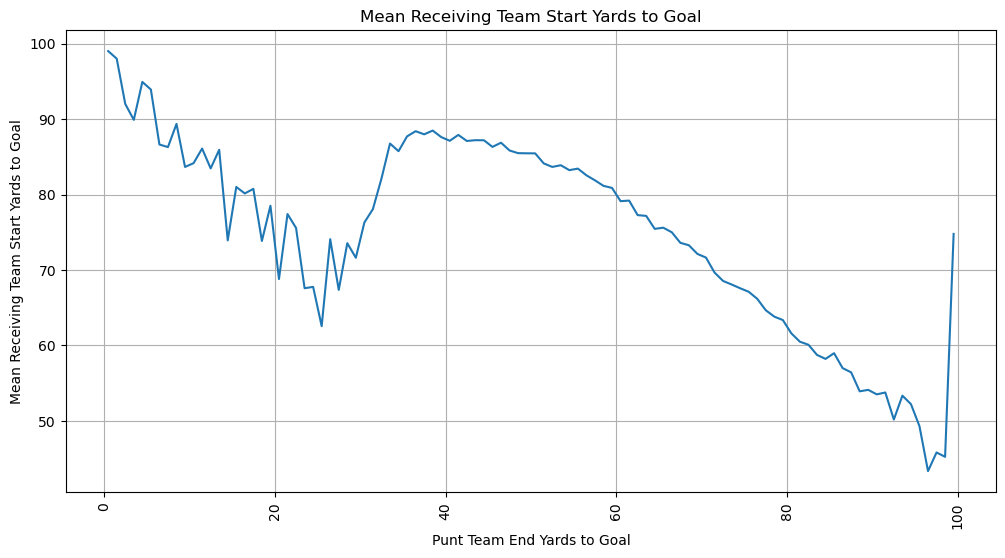

In [134]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [135]:
df_punts = df_punts.query('punt_team_end_yards_to_goal >= 40').reset_index(drop=True)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34514/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


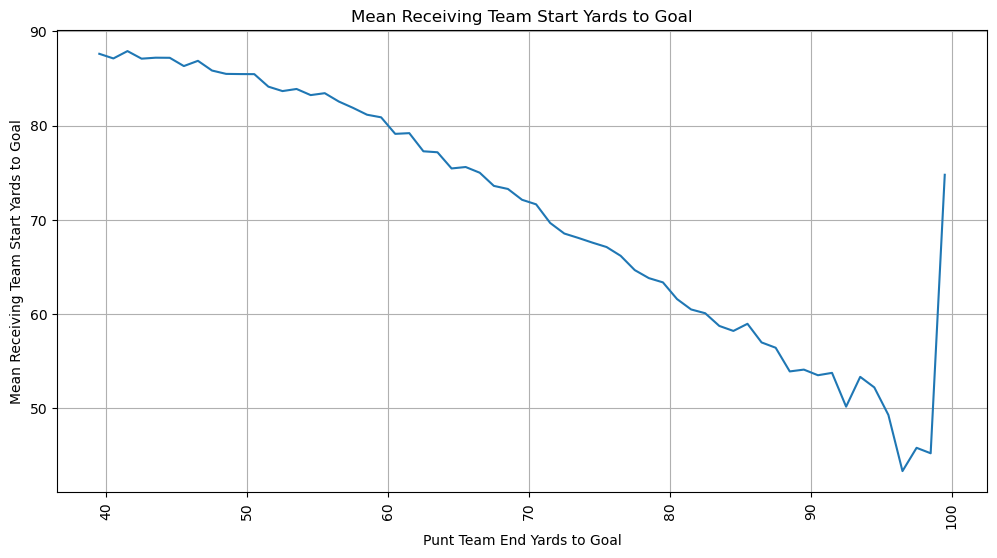

In [136]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [28]:
df_punts.head()

,game_id,drive_id,drive_number,season,week,season_type,completed,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,offense_conference,defense,defense_conference,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,receiving_team_points_scored,punting_team_points_scored,start_drive_pct_game_played,end_drive_pct_game_played,punt_drive_start_pct_game_played,punt_drive_start_yards_to_goal
0,302450194,30245019403,2,2010,1,regular,True,194,Ohio State,Big Ten,fbs,276,Marshall,Conference USA,fbs,Marshall,Conference USA,Ohio State,Big Ten,False,1,80,80,1,75,75,3,5,PUNT,False,0,0,0.021667,0.058056,0.058056,49.0
1,302450194,30245019406,5,2010,1,regular,True,194,Ohio State,Big Ten,fbs,276,Marshall,Conference USA,fbs,Ohio State,Big Ten,Marshall,Conference USA,False,1,24,76,1,60,40,5,36,PUNT,True,0,0,0.091389,0.127222,0.127222,80.0
2,302450194,30245019407,6,2010,1,regular,True,194,Ohio State,Big Ten,fbs,276,Marshall,Conference USA,fbs,Marshall,Conference USA,Ohio State,Big Ten,False,1,80,80,1,68,68,6,12,PUNT,False,0,0,0.127222,0.162778,0.162778,55.0
3,302450194,30245019411,10,2010,1,regular,True,194,Ohio State,Big Ten,fbs,276,Marshall,Conference USA,fbs,Marshall,Conference USA,Ohio State,Big Ten,False,1,76,76,2,47,47,5,29,PUNT,False,0,0,0.227222,0.270278,0.270278,84.0
4,302450194,30245019412,11,2010,1,regular,True,194,Ohio State,Big Ten,fbs,276,Marshall,Conference USA,fbs,Ohio State,Big Ten,Marshall,Conference USA,False,2,16,84,2,38,62,5,22,PUNT,True,0,0,0.270278,0.322500,0.322500,79.0


In [137]:
df_punts.columns

Index(['game_id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
       'away_id', 'away_team', 'away_conference', 'away_division', 'offense',
       'defense', 'drive_id', 'drive_number', 'start_yards_to_goal',
       'punt_team_end_yards_to_goal', 'drive_result', 'end_offense_score',
       'end_defense_score', 'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds', 'game_indoors',
       'temperature', 'dew_point', 'humidity', 'precipitation', 'snowfall',
       'wind_speed', 'pressure', 'weather_condition', 'elevation', 'grass',
       'home_pregame_elo', 'away_pregame_elo', 'punt_team_end_pct_game_played',
       'score_diff', 'is_home_team', 'offense_division', 'defense_division',
       'punting_team_pregame_elo', 'receiving_team_pregame_elo',
       'receiving_team_poin

## 5. Modeling

In [140]:
data = (
    df_punts[['game_id',
       'punt_team_end_yards_to_goal', 'is_home_team', 
       'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
       'punt_team_end_pct_game_played', 'score_diff',
       'punting_team_pregame_elo', 'receiving_team_pregame_elo']]
    .rename(columns={
        'punt_team_end_pct_game_played': 'pct_game_played',
    })
)
target = df_punts[['receiving_team_start_yards_to_goal']]

# Split into 80-20 train val set by game_id
game_ids = df_punts.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
target_train = target[target.index.isin(data_train.index)]

data_test = data[data.game_id.isin(game_ids_test)].drop(columns='game_id')
target_test = target[target.index.isin(data_test.index)]

In [141]:
data.head()

,game_id,punt_team_end_yards_to_goal,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,pct_game_played,score_diff,punting_team_pregame_elo,receiving_team_pregame_elo
0,400547829,40.0,-1,False,22.998209,4.7,0.0,82.9,False,0.278333,7.0,1969.442551,1496.329278
1,400547829,54.0,-1,False,22.998209,4.7,0.0,82.9,False,0.335278,7.0,1969.442551,1496.329278
2,400547829,44.0,-1,False,22.998209,4.7,0.0,82.9,False,0.696667,0.0,1969.442551,1496.329278
3,400548091,49.0,-1,False,267.453003,8.1,0.0,69.3,False,0.617778,-48.0,818.108995,2440.742085
4,400548091,42.0,1,False,267.453003,8.1,0.0,69.3,False,0.785278,52.0,2440.742085,818.108995


In [142]:
data.isna().sum()

game_id                        0
punt_team_end_yards_to_goal    0
is_home_team                   0
grass                          0
elevation                      0
wind_speed                     0
precipitation                  0
temperature                    0
game_indoors                   0
pct_game_played                0
score_diff                     0
punting_team_pregame_elo       0
receiving_team_pregame_elo     0
dtype: int64

In [146]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    game_ids = data_train.game_id.unique()
    game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=42)
  
    train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
    valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
    train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
    valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()
  
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    feature_names = train_x.columns.tolist()
    monotonic_constraints_map = {
        "punt_team_end_yards_to_goal": -1,
        "wind_speed": -1,
        "elevation": 1,
        "is_home_team": 1,
        "precipitation": -1,
        "game_indoors": 1,
    }
    monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

    interaction_constraints = [
        ["punting_team_pregame_elo", "receiving_team_pregame_elo", "score_diff", "pct_game_played"],
    ]
  
    param = {
        "nthread": -1,
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
        "interaction_constraints": interaction_constraints,
        "monotone_constraints": monotonic_constraints,
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.005, 0.3, step=0.005),
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 20, step=1),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return mean_absolute_error(valid_y, preds)

storage = "sqlite:///studies/punt_hyperopt.db"
study = optuna.create_study(
    study_name="punt_yardline_hyperopt", 
    storage=storage, 
    direction="minimize", 
    load_if_exists=True
)
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

[I 2025-03-30 16:56:40,912] A new study created in RDB with name: punt_yardline_hyperopt
[I 2025-03-30 16:56:41,145] Trial 0 finished with value: 7.905991310653457 and parameters: {'lambda': 0.6856792065596519, 'alpha': 0.004049075077913609, 'eta': 0.165, 'max_depth': 5, 'min_child_weight': 15.0, 'gamma': 0.00040224774536904676, 'grow_policy': 'lossguide', 'subsample': 0.7790167308709366, 'colsample_bytree': 0.6144312760036859}. Best is trial 0 with value: 7.905991310653457.
[I 2025-03-30 16:56:41,422] Trial 1 finished with value: 7.902659907562899 and parameters: {'lambda': 1.311853713833584e-05, 'alpha': 0.0016330129439095255, 'eta': 0.135, 'max_depth': 3, 'min_child_weight': 5.0, 'gamma': 1.6658172798377046e-05, 'grow_policy': 'lossguide', 'subsample': 0.6694602462000832, 'colsample_bytree': 0.7894309474990329}. Best is trial 1 with value: 7.902659907562899.
[I 2025-03-30 16:56:41,598] Trial 2 finished with value: 7.907400511162793 and parameters: {'lambda': 0.00022585387909729223, 

Best parameters: {'lambda': 0.5341514157770445, 'alpha': 0.0001754926422326678, 'eta': 0.02, 'max_depth': 3, 'min_child_weight': 17.0, 'gamma': 2.0904767439575245e-08, 'grow_policy': 'depthwise', 'subsample': 0.5541396293800149, 'colsample_bytree': 0.7057696407402034}
Best value: 7.89774011344386


[0]	train-mae:11.03081	eval-mae:11.15713
[1]	train-mae:10.92192	eval-mae:11.04742
[2]	train-mae:10.81355	eval-mae:10.93792
[3]	train-mae:10.70700	eval-mae:10.82992
[4]	train-mae:10.60526	eval-mae:10.72725
[5]	train-mae:10.50665	eval-mae:10.62718
[6]	train-mae:10.40833	eval-mae:10.52791
[7]	train-mae:10.40471	eval-mae:10.52480
[8]	train-mae:10.40227	eval-mae:10.52260
[9]	train-mae:10.30783	eval-mae:10.42525
[10]	train-mae:10.30466	eval-mae:10.42299
[11]	train-mae:10.21024	eval-mae:10.32621
[12]	train-mae:10.12021	eval-mae:10.23395
[13]	train-mae:10.03201	eval-mae:10.14324
[14]	train-mae:10.02978	eval-mae:10.14175
[15]	train-mae:9.95645	eval-mae:10.06603
[16]	train-mae:9.88529	eval-mae:9.99272
[17]	train-mae:9.81796	eval-mae:9.92300
[18]	train-mae:9.75199	eval-mae:9.85392
[19]	train-mae:9.68810	eval-mae:9.78666
[20]	train-mae:9.62807	eval-mae:9.72404
[21]	train-mae:9.62581	eval-mae:9.72245
[22]	train-mae:9.56745	eval-mae:9.66203
[23]	train-mae:9.51060	eval-mae:9.60349
[24]	train-mae:9.45

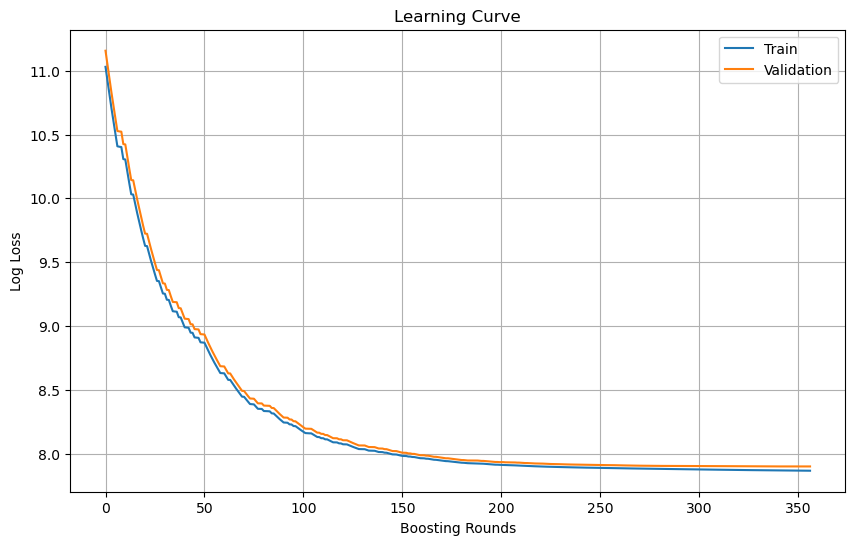

In [147]:
# Get the best parameters from the Optuna study
best_params = {'lambda': 0.53, 'alpha': 0.00017, 'eta': 0.02, 'max_depth': 3, 
               'min_child_weight': 17.0, 'gamma': 0, 'grow_policy': 'depthwise', 
               'subsample': 0.55, 'colsample_bytree': 0.7}

# Perform train-validation split
game_ids = data_train.game_id.unique()
game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=42)

train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

feature_names = train_x.columns.tolist()
monotonic_constraints_map = {
    "punt_team_end_yards_to_goal": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "game_indoors": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

interaction_constraints = [
    ["punting_team_pregame_elo", "receiving_team_pregame_elo", "score_diff", "pct_game_played"],
]
  
best_params.update({
    "objective": "reg:absoluteerror",
    "eval_metric": "mae",
    "interaction_constraints": interaction_constraints,
    "monotone_constraints": monotonic_constraints,
    "nthread": -1,
    "booster": "gbtree",
})

# Train the model with early stopping
evals_result = {}
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "eval")],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

preds = model.predict(dtrain)
mean_absolute_error(train_y, preds)
print(f"Train MAE: {mean_absolute_error(train_y, preds)}")
preds = model.predict(dvalid)
mean_absolute_error(valid_y, preds)
print(f"Validation MAE: {mean_absolute_error(valid_y, preds)}")

# Plot the learning curve
def plot_learning_curve(evals_result):
    train_metric = evals_result["train"]["mae"]
    eval_metric = evals_result["eval"]["mae"]

    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label="Train")
    plt.plot(eval_metric, label="Validation")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Log Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(evals_result)

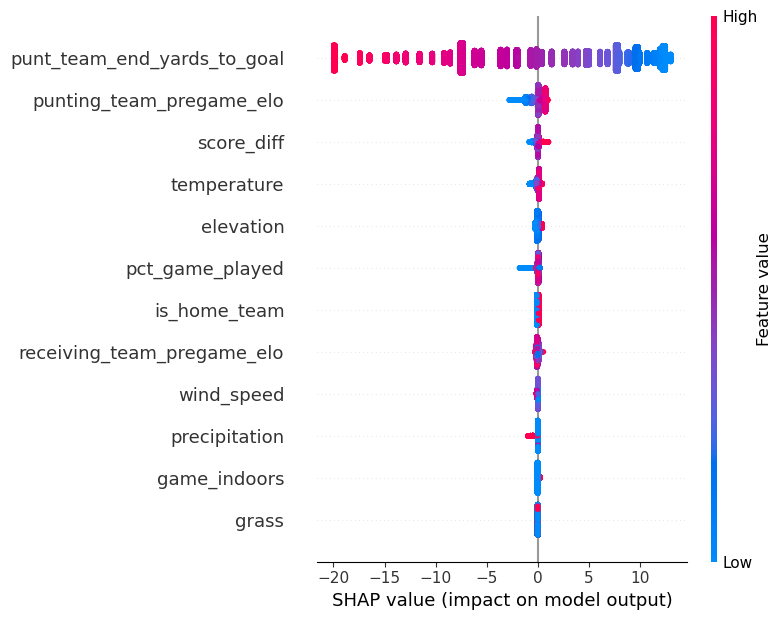

In [148]:
# SHAP values for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# Plot SHAP summary
shap.summary_plot(shap_values, train_x)

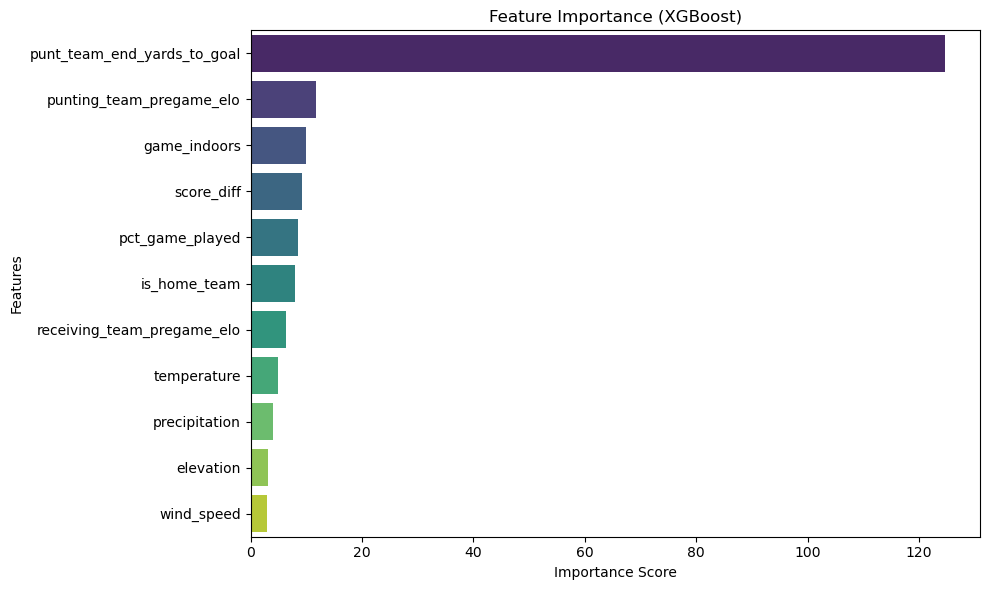

In [149]:
def plot_feature_importance(model):
    # Get feature importance scores
    importance = model.get_score(importance_type="gain")  # weight, gain, cover
    
    # Convert to a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        "Feature": list(importance.keys()),
        "Importance": list(importance.values())
    }).sort_values(by="Importance", ascending=False)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis",  # Custom color palette
        hue="Feature",      # Assign `Feature` to `hue`
        dodge=False         # Avoid splitting bars
    )
    plt.title("Feature Importance (XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)  # Remove the legend
    plt.tight_layout()
    plt.show()

# Call the function
plot_feature_importance(model)

In [150]:
dtest = xgb.DMatrix(data_test)
preds = model.predict(dtest)
mae = mean_absolute_error(target_test, preds)
print(f"Test MAE: {mae}")

Test MAE: 7.829651832580566


In [153]:
#make predictions on complete dataset
data_all = data.drop(columns='game_id')
dall = xgb.DMatrix(data_all)
preds_all = model.predict(dall)
df_punts['pred_yards_to_goal'] = preds_all

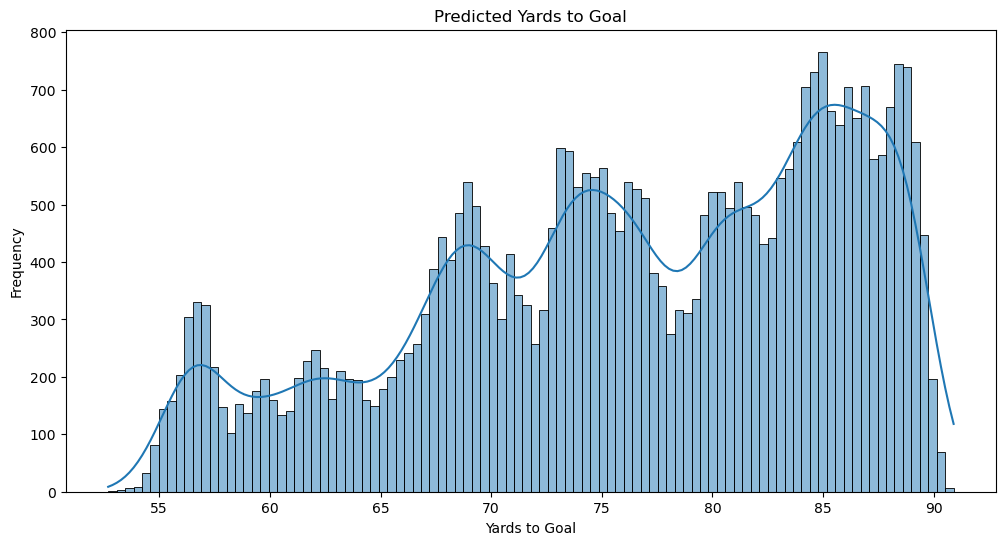

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df_punts.pred_yards_to_goal, bins=100, kde=True)
plt.title("Predicted Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()


In [159]:
df_punts.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,punt_team_end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,punt_team_end_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,receiving_team_start_pct_game_played,receiving_team_start_yards_to_goal,pred_yards_to_goal
0,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,154,Wake Forest,ACC,fbs,Wake Forest,UL Monroe,4005478296,6.0,96.0,40.0,PUNT,7.0,0.0,0.0,7.0,1.0,1.0,44.0,2.0,13.0,18.0,False,82.9,72.1,70.0,0.0,0.0,4.7,1013.0,None,22.998209,False,1496.329278,1969.442551,0.278333,7.0,-1,fbs,fbs,1969.442551,1496.329278,0.0,0.0,0.278333,60.0,89.203629
1,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,154,Wake Forest,ACC,fbs,Wake Forest,UL Monroe,4005478298,8.0,90.0,54.0,PUNT,7.0,0.0,0.0,7.0,2.0,12.0,24.0,2.0,9.0,53.0,False,82.9,72.1,70.0,0.0,0.0,4.7,1013.0,None,22.998209,False,1496.329278,1969.442551,0.335278,7.0,-1,fbs,fbs,1969.442551,1496.329278,0.0,0.0,0.335278,46.0,84.175095
2,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,154,Wake Forest,ACC,fbs,Wake Forest,UL Monroe,40054782919,19.0,75.0,44.0,PUNT,10.0,10.0,10.0,10.0,3.0,4.0,2.0,3.0,3.0,12.0,False,82.9,72.1,70.0,0.0,0.0,4.7,1013.0,None,22.998209,False,1496.329278,1969.442551,0.696667,0.0,-1,fbs,fbs,1969.442551,1496.329278,0.0,0.0,0.696667,56.0,88.242935
3,400548091,2014,1,regular,True,False,3764.0,2459,Northern Illinois,Mid-American,fbs,2506,Presbyterian,Big South,fcs,Presbyterian,Northern Illinois,40054809119,19.0,80.0,49.0,PUNT,0.0,48.0,48.0,0.0,3.0,11.0,26.0,3.0,7.0,56.0,False,69.3,59.9,72.0,0.0,0.0,8.1,1017.1,None,267.453003,False,2440.742085,818.108995,0.617778,-48.0,-1,fcs,fbs,818.108995,2440.742085,0.0,0.0,0.617778,80.0,84.345360
4,400548091,2014,1,regular,True,False,3764.0,2459,Northern Illinois,Mid-American,fbs,2506,Presbyterian,Big South,fcs,Northern Illinois,Presbyterian,40054809124,24.0,59.0,42.0,PUNT,55.0,3.0,3.0,55.0,3.0,0.0,0.0,4.0,12.0,53.0,False,69.3,59.9,72.0,0.0,0.0,8.1,1017.1,None,267.453003,False,2440.742085,818.108995,0.785278,52.0,1,fbs,fcs,2440.742085,818.108995,0.0,0.0,0.785278,90.0,89.583015


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34514/2163472551.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


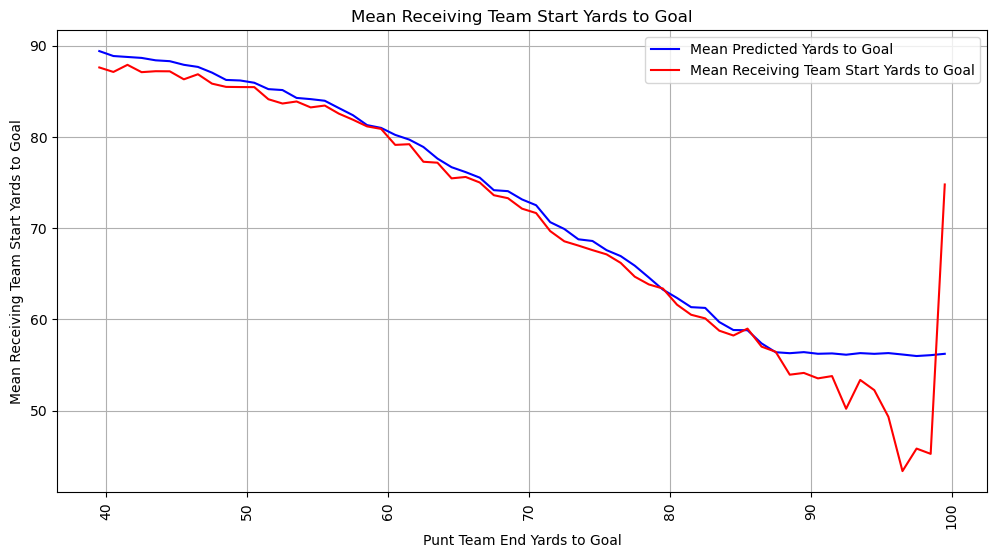

In [162]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(
        pred_yards_to_goal=('pred_yards_to_goal', 'mean'),
        receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean')
    )
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='pred_yards_to_goal', 
    data=df_punt_start_yards_to_goal,
    color='blue',
    label='Mean Predicted Yards to Goal'
)
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal,
    color='red',
    label='Mean Receiving Team Start Yards to Goal'
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

In [155]:
#TODO: anything inside of 40 yards to goal from punting team, predict default receiving team start yards to goal